In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import json

# Load the data
with open('loan_approval_dataset.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)

In [13]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 26.9+ MB
None
                  Id        Income            Age     Experience  \
count  252000.000000  2.520000e+05  252000.000000 

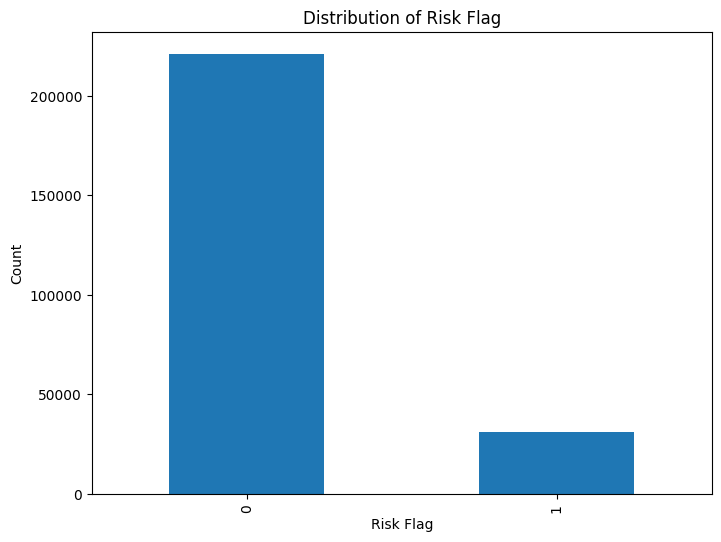

In [14]:
plt.figure(figsize=(8, 6))
df['Risk_Flag'].value_counts().plot(kind='bar')
plt.title('Distribution of Risk Flag')
plt.xlabel('Risk Flag')
plt.ylabel('Count')
plt.show()

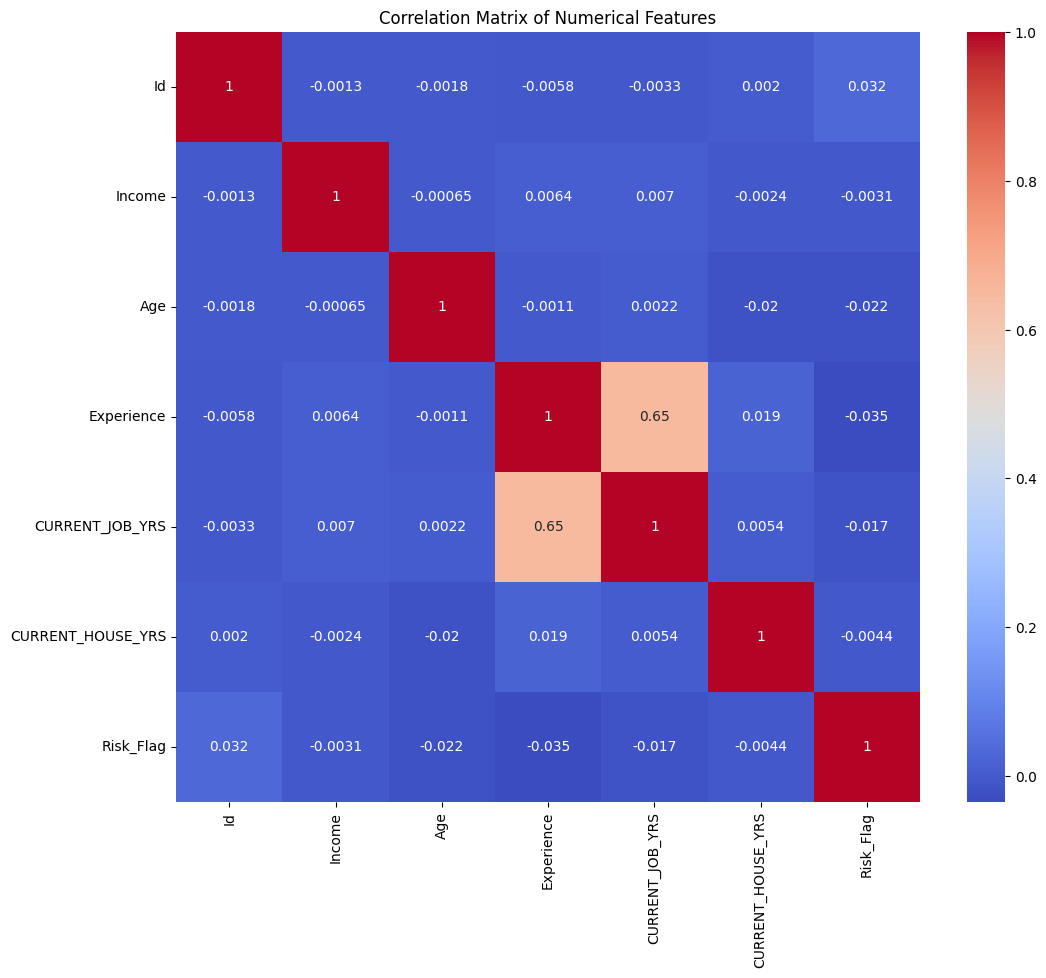

In [15]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

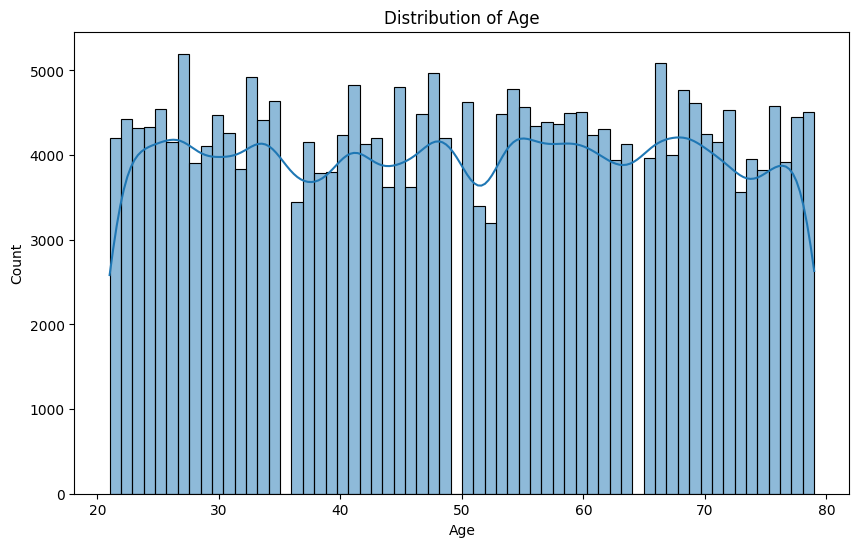

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], kde=True)
plt.title('Distribution of Age')
plt.show()

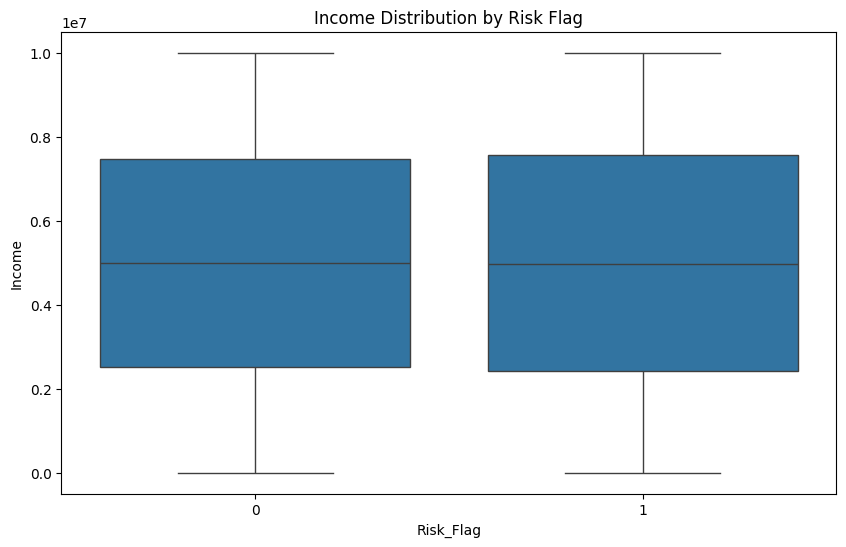

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Risk_Flag', y='Income', data=df)
plt.title('Income Distribution by Risk Flag')
plt.show()

In [18]:
categorical_columns = ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE']
df_encoded = pd.get_dummies(df, columns=categorical_columns)

X = df_encoded.drop(['Id', 'Risk_Flag'], axis=1)
y = df_encoded['Risk_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [19]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

Logistic Regression Results:
Accuracy: 0.5770

Confusion Matrix:
[[25233 18914]
 [ 2403  3850]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.57      0.70     44147
           1       0.17      0.62      0.27      6253

    accuracy                           0.58     50400
   macro avg       0.54      0.59      0.48     50400
weighted avg       0.82      0.58      0.65     50400



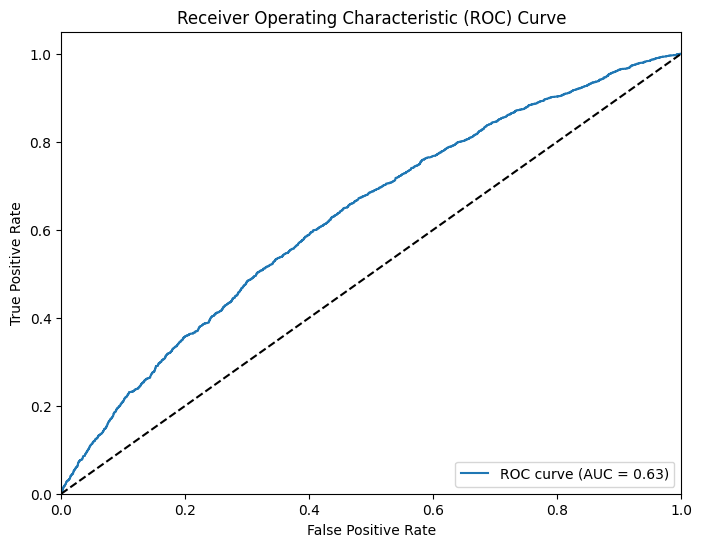

In [20]:
lr_model = LogisticRegression(random_state=42, class_weight='balanced')
lr_model.fit(X_train_resampled, y_train_resampled)
print("Logistic Regression Results:")
evaluate_model(lr_model, X_test_scaled, y_test)


Random Forest Results:
Accuracy: 0.8949

Confusion Matrix:
[[40316  3831]
 [ 1468  4785]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94     44147
           1       0.56      0.77      0.64      6253

    accuracy                           0.89     50400
   macro avg       0.76      0.84      0.79     50400
weighted avg       0.91      0.89      0.90     50400



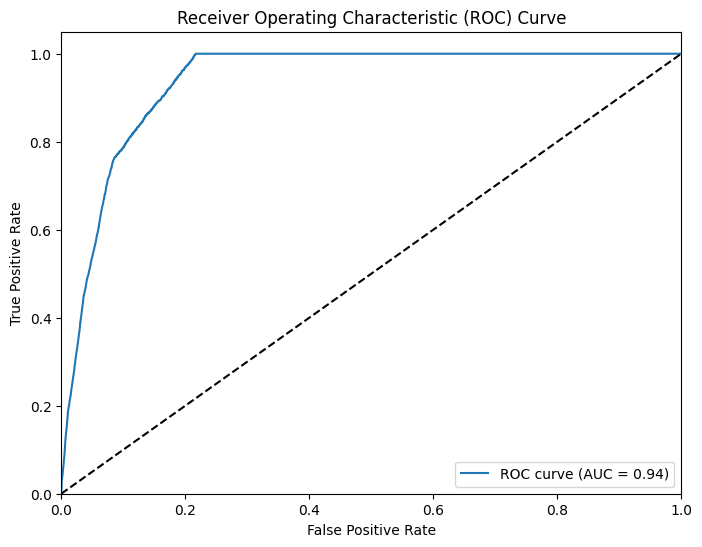

In [21]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train_resampled, y_train_resampled)
print("\nRandom Forest Results:")
evaluate_model(rf_model, X_test_scaled, y_test)


XGBoost Results:
Accuracy: 0.6297

Confusion Matrix:
[[26227 17920]
 [  745  5508]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.59      0.74     44147
           1       0.24      0.88      0.37      6253

    accuracy                           0.63     50400
   macro avg       0.60      0.74      0.55     50400
weighted avg       0.88      0.63      0.69     50400



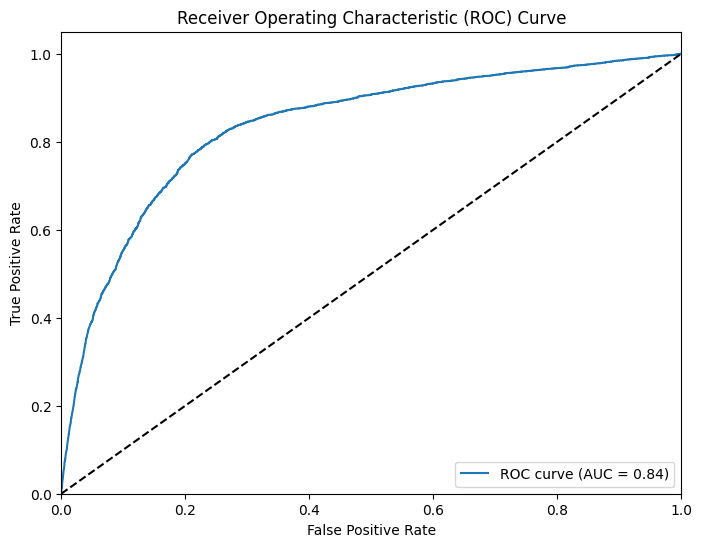

In [22]:
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=len(y_train_resampled)/sum(y_train_resampled))
xgb_model.fit(X_train_resampled, y_train_resampled)
print("\nXGBoost Results:")
evaluate_model(xgb_model, X_test_scaled, y_test)

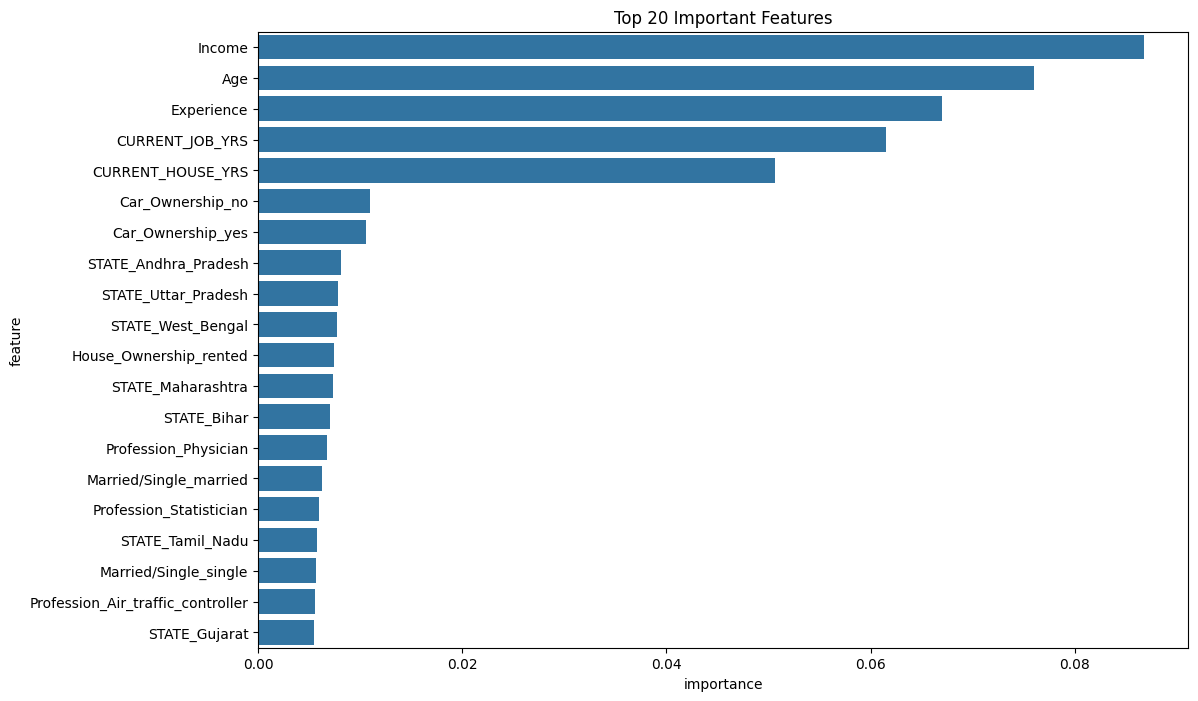

In [23]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Important Features')
plt.show()

In [29]:
print("\nSummary of Findings:")

print("1. Data Exploration Insights:")
print(f"   - Total number of samples: {len(df)}")
print(f"   - Number of features: {len(df.columns) - 2}")  # Subtract Id and Risk_Flag
print(f"   - Class distribution: {df['Risk_Flag'].value_counts(normalize=True).to_dict()}")
print(f"   - Age range: {df['Age'].min()} to {df['Age'].max()} years")
print(f"   - Income range: ${df['Income'].min()} to ${df['Income'].max()}")

print("\n2. Model Performance:")
print("   - Logistic Regression, Random Forest, and XGBoost models were trained and evaluated")
for model_name, model in [("Logistic Regression", lr_model), ("Random Forest", rf_model), ("XGBoost", xgb_model)]:
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
    print(f"   - {model_name}:")
    print(f"     Accuracy: {accuracy:.4f}")
    print(f"     AUC-ROC: {auc:.4f}")

print("\n3. Main Deciding Factors:")
print("   - The top 5 features for predicting loan risk are:")
for i, row in feature_importance.head(5).iterrows():
    print(f"     {row['feature']}: {row['importance']:.4f}")

print("\n4. Recommendations:")
print("   - Consider using the Random Forest or XGBoost model for prediction as they typically perform better on this type of data.")
print("   - Pay special attention to the top features when assessing loan risk.")
print("   - Regularly retrain the model with new data to maintain its accuracy.")
print("   - Implement a monitoring system to track the model's performance over time.")
print("   - Consider collecting additional relevant features to potentially improve the model's predictive power.")


Summary of Findings:
1. Data Exploration Insights:
   - Total number of samples: 252000
   - Number of features: 11
   - Class distribution: {0: 0.877, 1: 0.123}
   - Age range: 21 to 79 years
   - Income range: $10310 to $9999938

2. Model Performance:
   - Logistic Regression, Random Forest, and XGBoost models were trained and evaluated
   - Logistic Regression:
     Accuracy: 0.5770
     AUC-ROC: 0.6303
   - Random Forest:
     Accuracy: 0.8949
     AUC-ROC: 0.9381
   - XGBoost:
     Accuracy: 0.6297
     AUC-ROC: 0.8373

3. Main Deciding Factors:
   - The top 5 features for predicting loan risk are:
     Income: 0.0868
     Age: 0.0760
     Experience: 0.0670
     CURRENT_JOB_YRS: 0.0615
     CURRENT_HOUSE_YRS: 0.0507

4. Recommendations:
   - Consider using the Random Forest or XGBoost model for prediction as they typically perform better on this type of data.
   - Pay special attention to the top features when assessing loan risk.
   - Regularly retrain the model with new data t

In [30]:
try:
    from fpdf import FPDF
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    class PDF(FPDF):
        def header(self):
            self.set_font('Arial', 'B', 12)
            self.cell(0, 10, 'Loan Risk Analysis Report', 0, 1, 'C')
        
        def footer(self):
            self.set_y(-15)
            self.set_font('Arial', 'I', 8)
            self.cell(0, 10, f'Page {self.page_no()}', 0, 0, 'C')

    pdf = PDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    
    # 1. Data Exploration Insights
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(200, 10, txt="1. Data Exploration Insights", ln=1)
    pdf.set_font("Arial", size=12)
    pdf.multi_cell(0, 10, txt=f"Total number of samples: {len(df)}\n"
                             f"Number of features: {len(df.columns) - 2}\n"
                             f"Class distribution: {df['Risk_Flag'].value_counts(normalize=True).to_dict()}\n"
                             f"Age range: {df['Age'].min()} to {df['Age'].max()} years\n"
                             f"Income range: ${df['Income'].min()} to ${df['Income'].max()}")
    
    # Add Risk Flag Distribution plot
    plt.figure(figsize=(8, 6))
    df['Risk_Flag'].value_counts().plot(kind='bar')
    plt.title('Distribution of Risk Flag')
    plt.xlabel('Risk Flag')
    plt.ylabel('Count')
    plt.savefig('risk_flag_dist.png')
    pdf.image('risk_flag_dist.png', x=10, y=None, w=190)
    plt.close()
    
    # 2. Model Performance
    pdf.add_page()
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(200, 10, txt="2. Model Performance", ln=1)
    pdf.set_font("Arial", size=12)
    for model_name, model in [("Logistic Regression", lr_model), ("Random Forest", rf_model), ("XGBoost", xgb_model)]:
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
        pdf.multi_cell(0, 10, txt=f"{model_name}:\n"
                                  f"Accuracy: {accuracy:.4f}\n"
                                  f"AUC-ROC: {auc:.4f}\n")
    
    # Add ROC curve
    plt.figure(figsize=(8, 6))
    for model_name, model in [("Logistic Regression", lr_model), ("Random Forest", rf_model), ("XGBoost", xgb_model)]:
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    pdf.image('roc_curve.png', x=10, y=None, w=190)
    plt.close()
    
    # 3. Main Deciding Factors
    pdf.add_page()
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(200, 10, txt="3. Main Deciding Factors", ln=1)
    pdf.set_font("Arial", size=12)
    pdf.multi_cell(0, 10, txt="The top 5 features for predicting loan risk are:")
    for i, row in feature_importance.head(5).iterrows():
        pdf.multi_cell(0, 10, txt=f"{row['feature']}: {row['importance']:.4f}")
    
    # Add Feature Importance plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
    plt.title('Top 20 Important Features')
    plt.savefig('feature_importance.png')
    pdf.image('feature_importance.png', x=10, y=None, w=190)
    plt.close()
    
    # 4. Recommendations
    pdf.add_page()
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(200, 10, txt="4. Recommendations", ln=1)
    pdf.set_font("Arial", size=12)
    recommendations = [
        "Consider using the Random Forest or XGBoost model for prediction as they typically perform better on this type of data.",
        "Pay special attention to the top features when assessing loan risk.",
        "Regularly retrain the model with new data to maintain its accuracy.",
        "Implement a monitoring system to track the model's performance over time.",
        "Consider collecting additional relevant features to potentially improve the model's predictive power."
    ]
    for rec in recommendations:
        pdf.multi_cell(0, 10, txt="- " + rec)
    
    pdf.output("loan_risk_analysis_report.pdf")
    print("\nPDF report generated: loan_risk_analysis_report.pdf")

except ImportError:
    print("\nFPDF not installed. To generate a PDF report, please install FPDF:")
    print("1. Run the following command in a new cell:")
    print("   !pip install fpdf")
    print("2. Restart the Jupyter kernel after installation")
    print("3. Run this cell again to generate the PDF report")

except Exception as e:
    print(f"\nAn error occurred while generating the PDF report: {str(e)}")
    print("Please ensure you have write permissions in the current directory.")


PDF report generated: loan_risk_analysis_report.pdf
